# Noise2Void Experiment

[CVPR 2019 : Noise2Void - Learning Denoising from Single Noisy Image](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf)

Key idea: 
- Blind-spot network(BSN), network learn the mapping between mask pixel(s) and every other pixels
- the expect of output identical to clean image when noise mean is zero and i.i.d and there traing data inf.

Pros: 
1. single noisy image denoising, has tremendous practicality on medical denoising task
2. can adaptive to any noise distribution since its learn denoising directly from noisy image 

Cons:
1. by masking certain pixel(s), the quality of denoising decrease, especially for high-frequency content
2. strong assumption of zero mean noise and pixels i.i.d, leading to poor performance when it dealing with structured noise 
3. denoising performance slightly degrade to N2N but still better than BM3D

In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from module.models import UNet2_5D
from module.datasets import MaskDataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss


import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4927044212818146); std:0.022372599691152573
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -24.626427916933984, 'noise_max': 25.3497884510521}


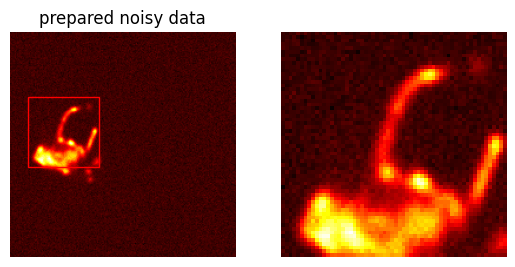

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gaussian_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

## Process Denoising

## 1. import denoising network

In [3]:
model = UNet2_5D(in_channels=3, out_channels=1)
model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192), (1, 192, 192), (1, 192, 192)])

The number of parameters of the network is:  138372097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
       BatchNorm2d-2         [-1, 64, 192, 192]             128
         LeakyReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,928
       BatchNorm2d-5         [-1, 64, 192, 192]             128
            Conv2d-6         [-1, 64, 192, 192]             256
         LeakyReLU-7         [-1, 64, 192, 192]               0
         UNetBlock-8         [-1, 64, 192, 192]               0
         MaxPool2d-9           [-1, 64, 96, 96]               0
           Conv2d-10          [-1, 128, 96, 96]          73,856
      BatchNorm2d-11          [-1, 128, 96, 96]             256
        LeakyReLU-12          [-1, 128, 96, 96]               0
           Conv2d-13          [-1, 128, 96, 96] 

## 2. create mask dataset and dataloader

In [4]:
# def split_tensor(data_tensor):
#     """split tensor into train, test, vali tensor

#     Args:
#         data_tensor (_type_): _description_

#     Returns:
#         _type_: _description_
#     """
#     test_tensor = data_tensor[0:1]
    
#     rest_tensor = data_tensor[1:]

#     total_samples = rest_tensor.shape[0]
    
#     train_ration = 0.8
#     train_length = int(train_ration * total_samples)
#     val_length = total_samples - train_length
    
    
#     train_subset, val_subset = random_split(rest_tensor, [train_length, val_length])
    
    
#     # Convert Subset back into tensors
#     train_tensor = train_subset.dataset[train_subset.indices]
#     val_tensor = val_subset.dataset[val_subset.indices]

#     return train_tensor, val_tensor, test_tensor


def split_data(data_array):
    """split ndarray into train, test, vali arrays

    Args:
        data_array (numpy.ndarray): The input data array.

    Returns:
        numpy.ndarray, numpy.ndarray, numpy.ndarray: Train, Validation, Test arrays.
    """
    test_array = data_array[0:1]
    rest_array = data_array[1:]

    total_samples = rest_array.shape[0]
    
    train_ration = 0.8
    train_length = int(train_ration * total_samples)
    val_length = total_samples - train_length
    
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    train_array = rest_array[indices[:train_length]]
    val_array = rest_array[indices[train_length:]]

    return train_array, val_array, test_array

In [5]:
## split ndarray data
train_data, val_data, test_data = split_data(noisy_data)



## add channel dim
train_tensor = torch.tensor(train_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
val_tensor = torch.tensor(val_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
test_tensor = torch.tensor(test_data[..., np.newaxis, :, :, :], dtype=torch.float32) 

print(f"train_tensor:\n {train_tensor.dtype}; shape:{train_tensor.shape}; range:({torch.min(train_tensor)},{torch.max(train_tensor)}); mean:{torch.mean(train_tensor)}; std:{torch.std(train_tensor)}")
print(f"val_tensor:\n {val_tensor.dtype}; shape:{val_tensor.shape}; range:({torch.min(val_tensor)},{torch.max(val_tensor)}); mean:{torch.mean(val_tensor)}; std:{torch.std(val_tensor)}")
print(f"test_tensor:\n {test_tensor.dtype}; shape:{test_tensor.shape}; range:({torch.min(test_tensor)},{torch.max(test_tensor)}); mean:{torch.mean(test_tensor)}; std:{torch.std(test_tensor)}")


## create dataset
num_mask = 1

train_dataset = MaskDataset(train_tensor, num_mask)
val_dataset = MaskDataset(val_tensor, num_mask)
test_dataset = MaskDataset(test_tensor, num_mask)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")


# create dataloader
batch_size = 32
num_workers = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_tensor:
 torch.float32; shape:torch.Size([8, 24, 1, 71, 192, 192]); range:(0.0,0.9951097369194031); mean:0.492766797542572; std:0.022389158606529236
val_tensor:
 torch.float32; shape:torch.Size([2, 24, 1, 71, 192, 192]); range:(0.006992261856794357,0.9904358386993408); mean:0.4927503764629364; std:0.022272983565926552
test_tensor:
 torch.float32; shape:torch.Size([1, 24, 1, 71, 192, 192]); range:(0.002076786942780018,1.0); mean:0.4927551746368408; std:0.02243882790207863
train_dataset: 13248
val_dataset: 3312
test_dataset: 1656


Batch 1
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5396267175674438,0.44163817167282104); mean:0.48989683389663696; std:0.009998779743909836
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0439517498016357,0.44163817167282104); mean:0.48991045355796814; std:0.010374910198152065
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5396267175674438,0.44163817167282104); mean:0.48989158868789673; std:0.01000194065272808
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5396267175674438,0.44163817167282104); mean:0.4898960292339325; std:0.010001018643379211


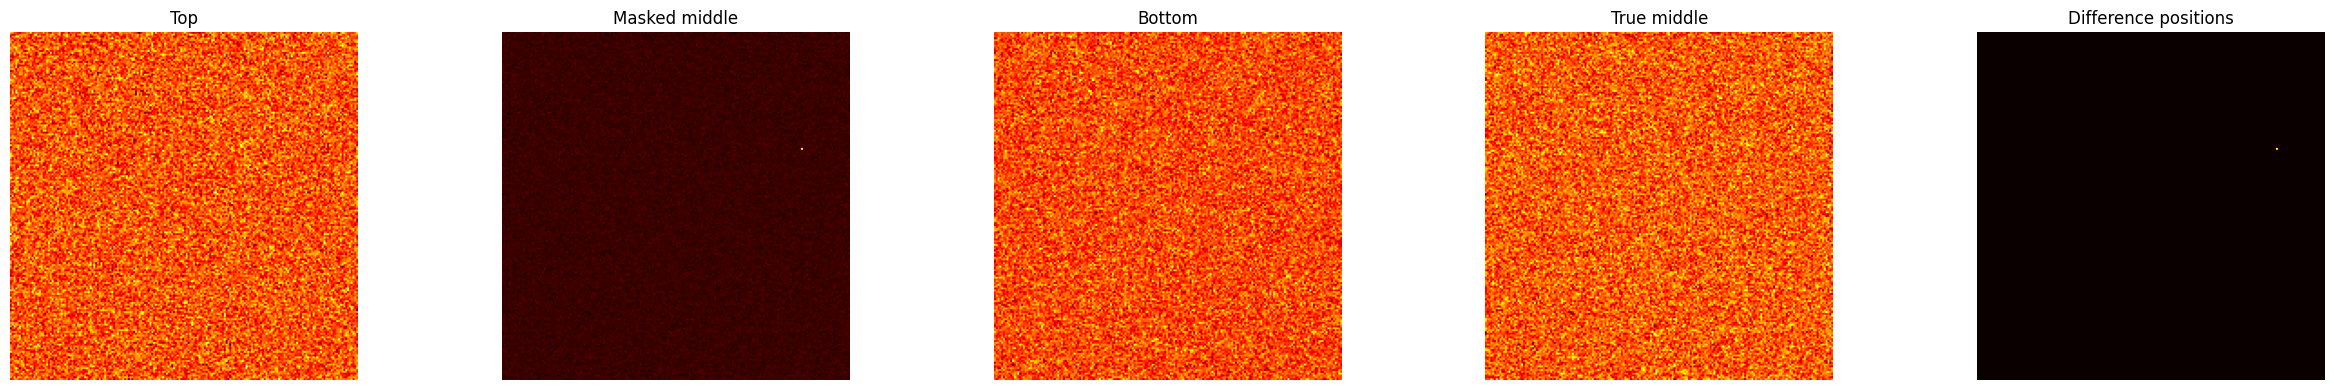

Batch 2
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5416002869606018,0.4392525851726532); mean:0.48988670110702515; std:0.010014474391937256
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.040616512298584,0.4392525851726532); mean:0.4899024963378906; std:0.010393942706286907
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5416002869606018,0.4392525851726532); mean:0.4898889362812042; std:0.010014122352004051
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5416002869606018,0.4392525851726532); mean:0.489888072013855; std:0.010014642961323261


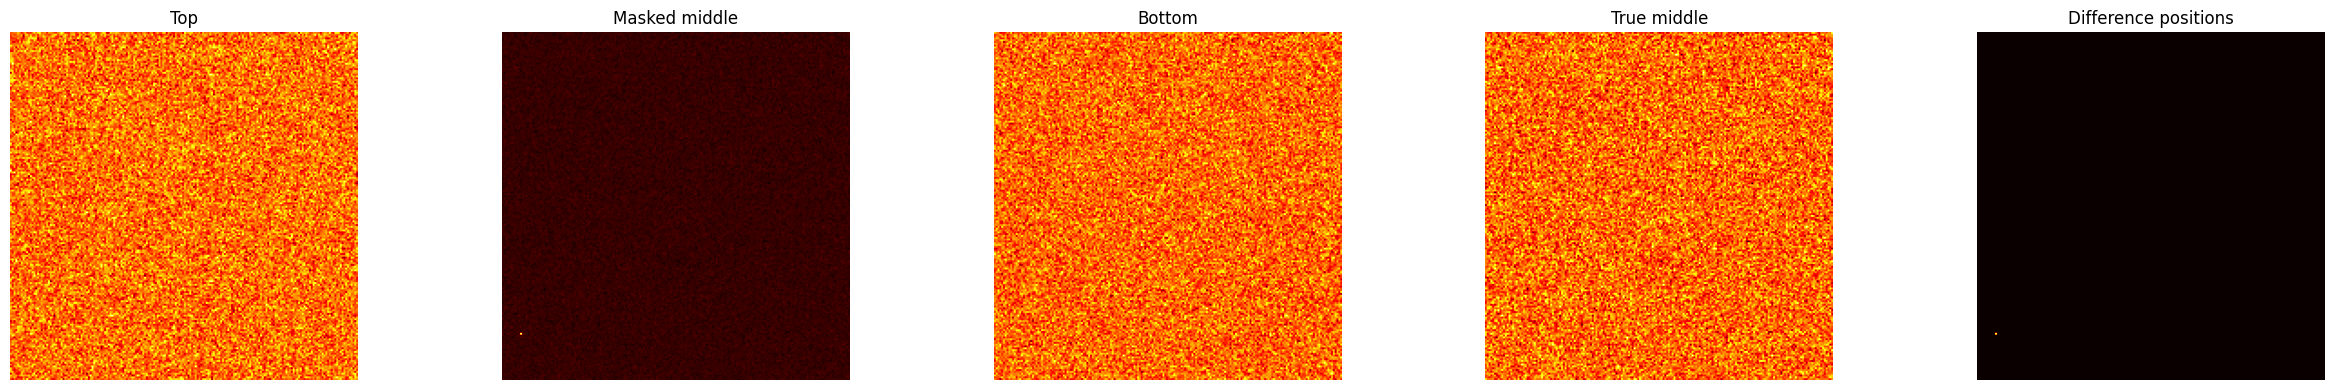

Batch 3
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5383895039558411,0.44038161635398865); mean:0.4898950159549713; std:0.009999302215874195
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0379412174224854,0.44038161635398865); mean:0.4899102747440338; std:0.010375111363828182
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5383895039558411,0.44038161635398865); mean:0.48989689350128174; std:0.010004800744354725
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5383895039558411,0.44038161635398865); mean:0.4898958206176758; std:0.01000034250319004


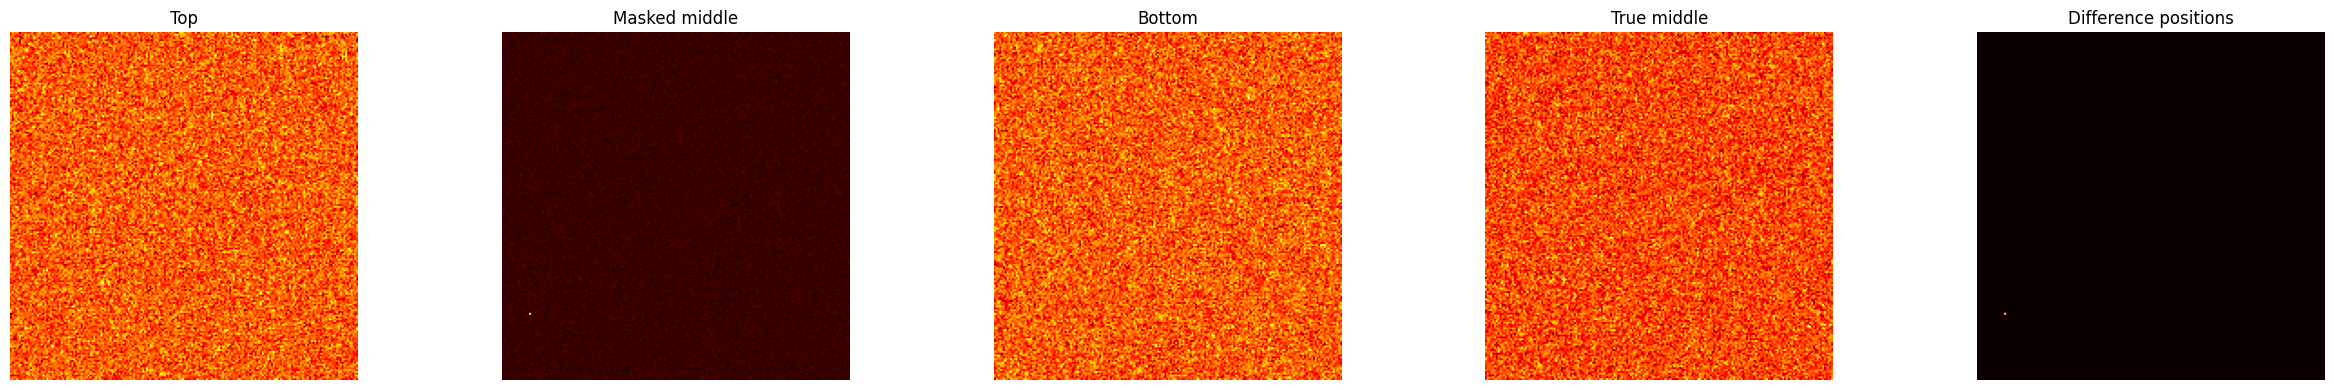

Batch 4
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5363434553146362,0.4396808445453644); mean:0.48989343643188477; std:0.010008306242525578
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0354816913604736,0.43477731943130493); mean:0.4899078905582428; std:0.010380163788795471
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5363434553146362,0.43477731943130493); mean:0.48989343643188477; std:0.01000406313687563
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.5363434553146362,0.43477731943130493); mean:0.48989349603652954; std:0.010006886906921864


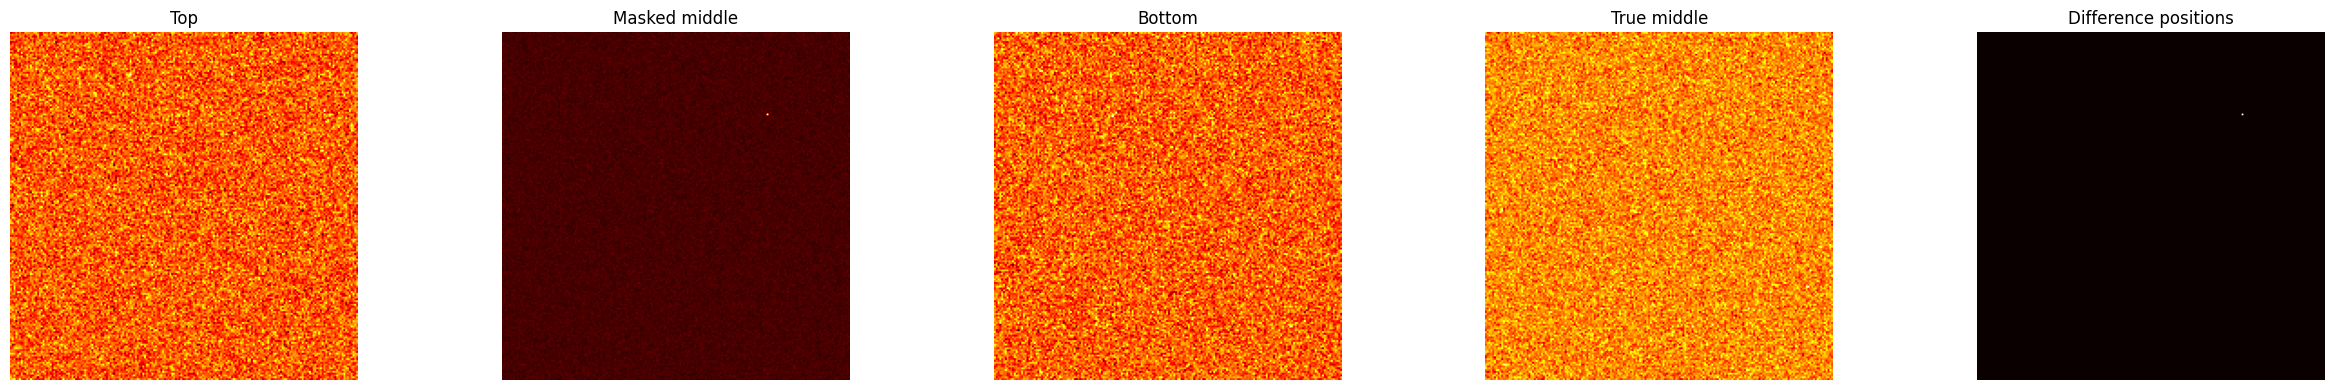

Batch 5
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9516905546188354,0.007110630162060261); mean:0.48986494541168213; std:0.013080863282084465
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.4385733604431152,0.007110630162060261); mean:0.4898824095726013; std:0.013604307547211647
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9516905546188354,0.007110630162060261); mean:0.48988139629364014; std:0.01300700195133686
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9516905546188354,0.007110630162060261); mean:0.489862859249115; std:0.013059010729193687


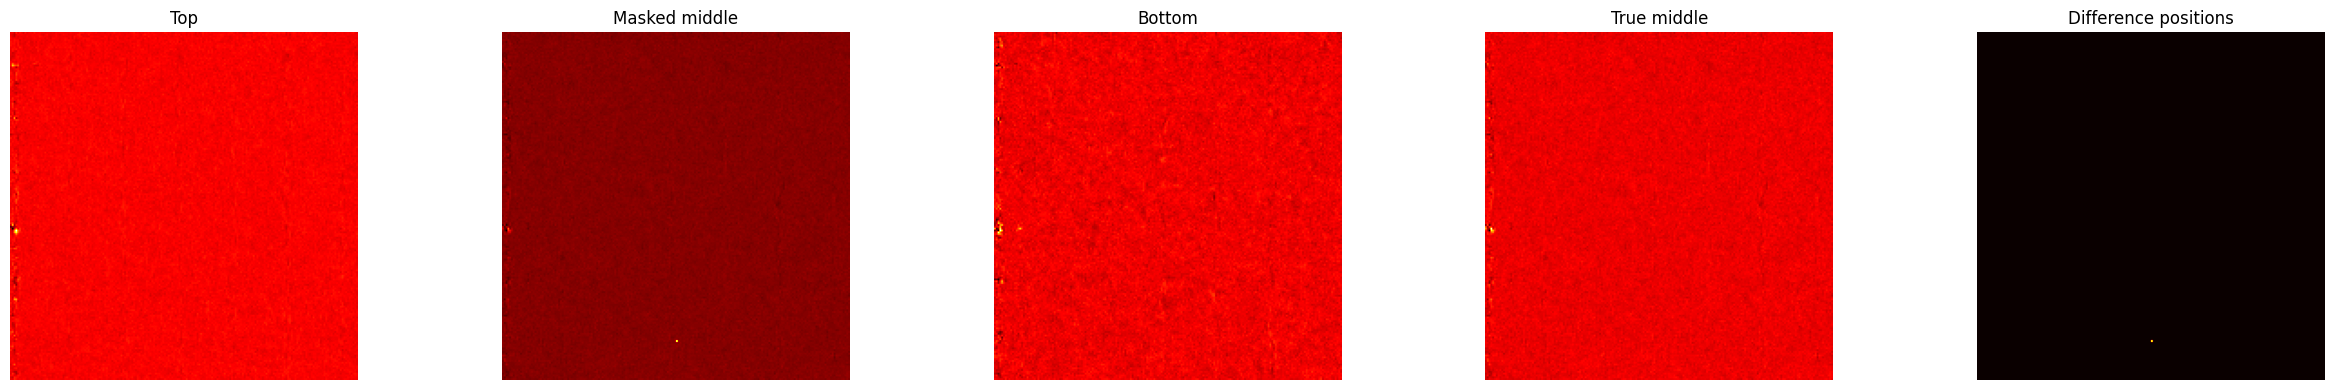

In [6]:
# example batch plot
num_batches_to_display = 5  # for example, show 3 batches

# Iterate through the DataLoader
for batch_idx, (top_slice, mask_middle_slice, bottom_slice, middle_slice) in enumerate(val_loader):
    
    # Print data details
    print(f"Batch {batch_idx + 1}")
    print(f"top_slice: {top_slice.dtype} {top_slice.shape} range:({torch.max(top_slice)},{torch.min(top_slice)}); mean:{torch.mean(top_slice)}; std:{torch.std(top_slice)}")
    print(f"mask_middle_slice: {mask_middle_slice.dtype} {mask_middle_slice.shape} range:({torch.max(mask_middle_slice)},{torch.min(mask_middle_slice)}); mean:{torch.mean(mask_middle_slice)}; std:{torch.std(mask_middle_slice)}")
    print(f"bottom_slice: {bottom_slice.dtype} {bottom_slice.shape} range:({torch.max(bottom_slice)},{torch.min(bottom_slice)}); mean:{torch.mean(bottom_slice)}; std:{torch.std(bottom_slice)}")
    print(f"middle_slice: {middle_slice.dtype} {middle_slice.shape} range:({torch.max(middle_slice)},{torch.min(middle_slice)}); mean:{torch.mean(middle_slice)}; std:{torch.std(middle_slice)}")

    # select the show baych index
    idx = -1

    fig, axes = plt.subplots(1, 5, figsize=(25, 4))

    axes[0].imshow(top_slice[idx].squeeze().numpy(), cmap='hot')
    axes[0].set_title('Top')

    axes[1].imshow(mask_middle_slice[idx].squeeze().numpy(), cmap='hot')
    axes[1].set_title('Masked middle')

    axes[2].imshow(bottom_slice[idx].squeeze().numpy(), cmap='hot')
    axes[2].set_title('Bottom')

    axes[3].imshow(middle_slice[idx].squeeze().numpy(), cmap='hot')
    axes[3].set_title('True middle')

    # Show difference
    difference = (mask_middle_slice[idx] != middle_slice[idx]).float().squeeze().numpy()

    canvas = np.zeros_like(difference)

    # Set the differing pixels to 1
    canvas[difference > 0] = 1

    axes[4].imshow(canvas, cmap='hot')
    axes[4].set_title('Difference positions')
    
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Break loop after displaying desired number of batches
    if batch_idx + 1 == num_batches_to_display:
        break


## 3.  define training modules 

In [7]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
        top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
        
        # Forward
        outputs = model(top_slice, mask_middle_slice, bottom_slice)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        loss = criterion(outputs, middle_slice)
        
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
            top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            outputs = model(top_slice, mask_middle_slice, bottom_slice)
            loss = criterion(outputs, middle_slice)
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss

# @timer_decorator
# def test(model, test_loader, device):
#     model.eval()
#     preds = []
#     targets = []
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
#             top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
#             pred = model(top_slice, mask_middle_slice, bottom_slice)
#             preds.append(pred.cpu()) # predict
#             targets.append(middle_slice.cpu()) # original input data
            
#     return preds, targets
# def test(model, test_loader, device, original_shape):
#     # 初始化两个全0的tensor用于存放预测和目标
#     preds = torch.zeros(original_shape).to(device)
#     targets = torch.zeros(original_shape).to(device)

#     model.eval()
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slices) in enumerate(pbar):
#             top_slice, mask_middle_slice, bottom_slice, middle_slices = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slices.to(device)
            
#             batch_preds = model(top_slice, mask_middle_slice, bottom_slice)
            
#             for b_idx, pred in enumerate(batch_preds):
#                 # 计算应该放置预测值和目标值的位置
#                 patience_idx = (idx * len(batch_preds) + b_idx) // (original_shape[1] * (original_shape[3] - 2))
#                 time_idx = ((idx * len(batch_preds) + b_idx) % (original_shape[1] * (original_shape[3] - 2))) // (original_shape[3] - 2)
#                 depth_idx = (idx * len(batch_preds) + b_idx) % (original_shape[3] - 2) + 1
                
#                 pred = pred.squeeze(0)
#                 middle_slice = middle_slices[b_idx].squeeze(0)
                
#                 preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
#                 targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice

#     return preds.cpu(), targets.cpu()

def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slice) in enumerate(pbar):
            top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
            batch_preds = model(top_slice, mask_middle_slice, bottom_slice)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1

                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice[b_idx]

    return preds.cpu(), targets.cpu()




@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {current_lr:.8e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model_epoch_{best_epoch}.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [8]:
# define loss, optimizer, lr_scheduler

criterion = nn.L1Loss()
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## 4. process training

In [ ]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 0.01069237, Validation Loss: 0.00476437, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2/200, Train Loss: 0.00458686, Validation Loss: 0.00674104, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3/200, Train Loss: 0.00341989, Validation Loss: 0.00267246, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4/200, Train Loss: 0.00380764, Validation Loss: 0.00401509, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/200, Train Loss: 0.00292252, Validation Loss: 0.00569222, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 6/200, Train Loss: 0.00102567, Validation Loss: 0.00092706, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7/200, Train Loss: 0.00159563, Validation Loss: 0.00196873, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8/200, Train Loss: 0.00141418, Validation Loss: 0.00122141, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9/200, Train Loss: 0.00156594, Validation Loss: 0.00124248, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/200, Train Loss: 0.00146789, Validation Loss: 0.00097574, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 11/200, Train Loss: 0.00071905, Validation Loss: 0.00096975, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 12/200, Train Loss: 0.00071890, Validation Loss: 0.00225043, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 13/200, Train Loss: 0.00072214, Validation Loss: 0.00083496, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 14/200, Train Loss: 0.00072783, Validation Loss: 0.00051377, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 15/200, Train Loss: 0.00073067, Validation Loss: 0.00046029, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 16/200, Train Loss: 0.00042500, Validation Loss: 0.00023853, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 17/200, Train Loss: 0.00039481, Validation Loss: 0.00073927, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 18/200, Train Loss: 0.00041092, Validation Loss: 0.00075810, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 19/200, Train Loss: 0.00048787, Validation Loss: 0.00071717, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 20/200, Train Loss: 0.00040573, Validation Loss: 0.00028140, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 21/200, Train Loss: 0.00031421, Validation Loss: 0.00017104, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 22/200, Train Loss: 0.00028566, Validation Loss: 0.00024212, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 23/200, Train Loss: 0.00030632, Validation Loss: 0.00064573, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 24/200, Train Loss: 0.00027828, Validation Loss: 0.00059858, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 25/200, Train Loss: 0.00027212, Validation Loss: 0.00061273, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 26/200, Train Loss: 0.00022065, Validation Loss: 0.00019459, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 27/200, Train Loss: 0.00021699, Validation Loss: 0.00020649, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 28/200, Train Loss: 0.00023021, Validation Loss: 0.00023989, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 29/200, Train Loss: 0.00022731, Validation Loss: 0.00016600, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 30/200, Train Loss: 0.00022562, Validation Loss: 0.00023917, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 31/200, Train Loss: 0.00017075, Validation Loss: 0.00043552, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 32/200, Train Loss: 0.00018312, Validation Loss: 0.00024029, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 33/200, Train Loss: 0.00017340, Validation Loss: 0.00013877, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 34/200, Train Loss: 0.00017299, Validation Loss: 0.00011985, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 35/200, Train Loss: 0.00018791, Validation Loss: 0.00011514, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 36/200, Train Loss: 0.00015221, Validation Loss: 0.00009925, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 37/200, Train Loss: 0.00015946, Validation Loss: 0.00011451, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 38/200, Train Loss: 0.00015981, Validation Loss: 0.00009934, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 39/200, Train Loss: 0.00016395, Validation Loss: 0.00010505, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 40/200, Train Loss: 0.00015406, Validation Loss: 0.00009901, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 41/200, Train Loss: 0.00014588, Validation Loss: 0.00009731, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 42/200, Train Loss: 0.00014257, Validation Loss: 0.00010254, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 43/200, Train Loss: 0.00013944, Validation Loss: 0.00018946, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 44/200, Train Loss: 0.00014697, Validation Loss: 0.00015961, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 45/200, Train Loss: 0.00013950, Validation Loss: 0.00014122, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 46/200, Train Loss: 0.00013434, Validation Loss: 0.00009852, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 47/200, Train Loss: 0.00013596, Validation Loss: 0.00010019, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 48/200, Train Loss: 0.00013323, Validation Loss: 0.00010352, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 49/200, Train Loss: 0.00014010, Validation Loss: 0.00009291, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 50/200, Train Loss: 0.00013481, Validation Loss: 0.00009837, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 51/200, Train Loss: 0.00013034, Validation Loss: 0.00009781, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 52/200, Train Loss: 0.00013102, Validation Loss: 0.00010092, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 53/200, Train Loss: 0.00013354, Validation Loss: 0.00011087, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 54/200, Train Loss: 0.00012966, Validation Loss: 0.00011013, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 55/200, Train Loss: 0.00013044, Validation Loss: 0.00011334, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 56/200, Train Loss: 0.00012990, Validation Loss: 0.00009401, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 57/200, Train Loss: 0.00012526, Validation Loss: 0.00009446, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 58/200, Train Loss: 0.00012579, Validation Loss: 0.00010052, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 59/200, Train Loss: 0.00012812, Validation Loss: 0.00009114, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 60/200, Train Loss: 0.00013034, Validation Loss: 0.00009208, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 61/200, Train Loss: 0.00012650, Validation Loss: 0.00009287, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 62/200, Train Loss: 0.00012646, Validation Loss: 0.00009708, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 63/200, Train Loss: 0.00012789, Validation Loss: 0.00009905, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

## 5. process denoising

In [ ]:
# load best model
model.load_state_dict(torch.load('check_points/best_model_epoch_42.pth'))


In [ ]:
# denoising 
preds, targets = test(model, test_loader, device, test_dataset)

In [ ]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[11, 38], title='denoised')
display_image_in_detail(true_data[11, 38], title='true')

## 6. metrics evaluation

In [ ]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_4d_image(restored_data)

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM4D/PT_20p 150_120 OSEM_real_0.00_batch'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)